In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # much faster than svg when generating lots of points
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.anova as sa
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

# set print precision
np.set_printoptions(precision=5, suppress=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [2]:
# load train data to build model
df = pd.read_csv('data/train.csv')
df.head()
df.dtypes

category                 object
rating                  float64
reviews                 float64
installs                float64
type                     object
price                   float64
content_rating           object
app_size                float64
last_updated_encoded      int64
dtype: object

# Data Exploration
* Categorical, bar charts - Amee 
* Histograms - Flora
* Scatter plots matrix of all numeric variables - Sandy
* Correlation analysis for numeric variables (heatmap)  - Sandy 


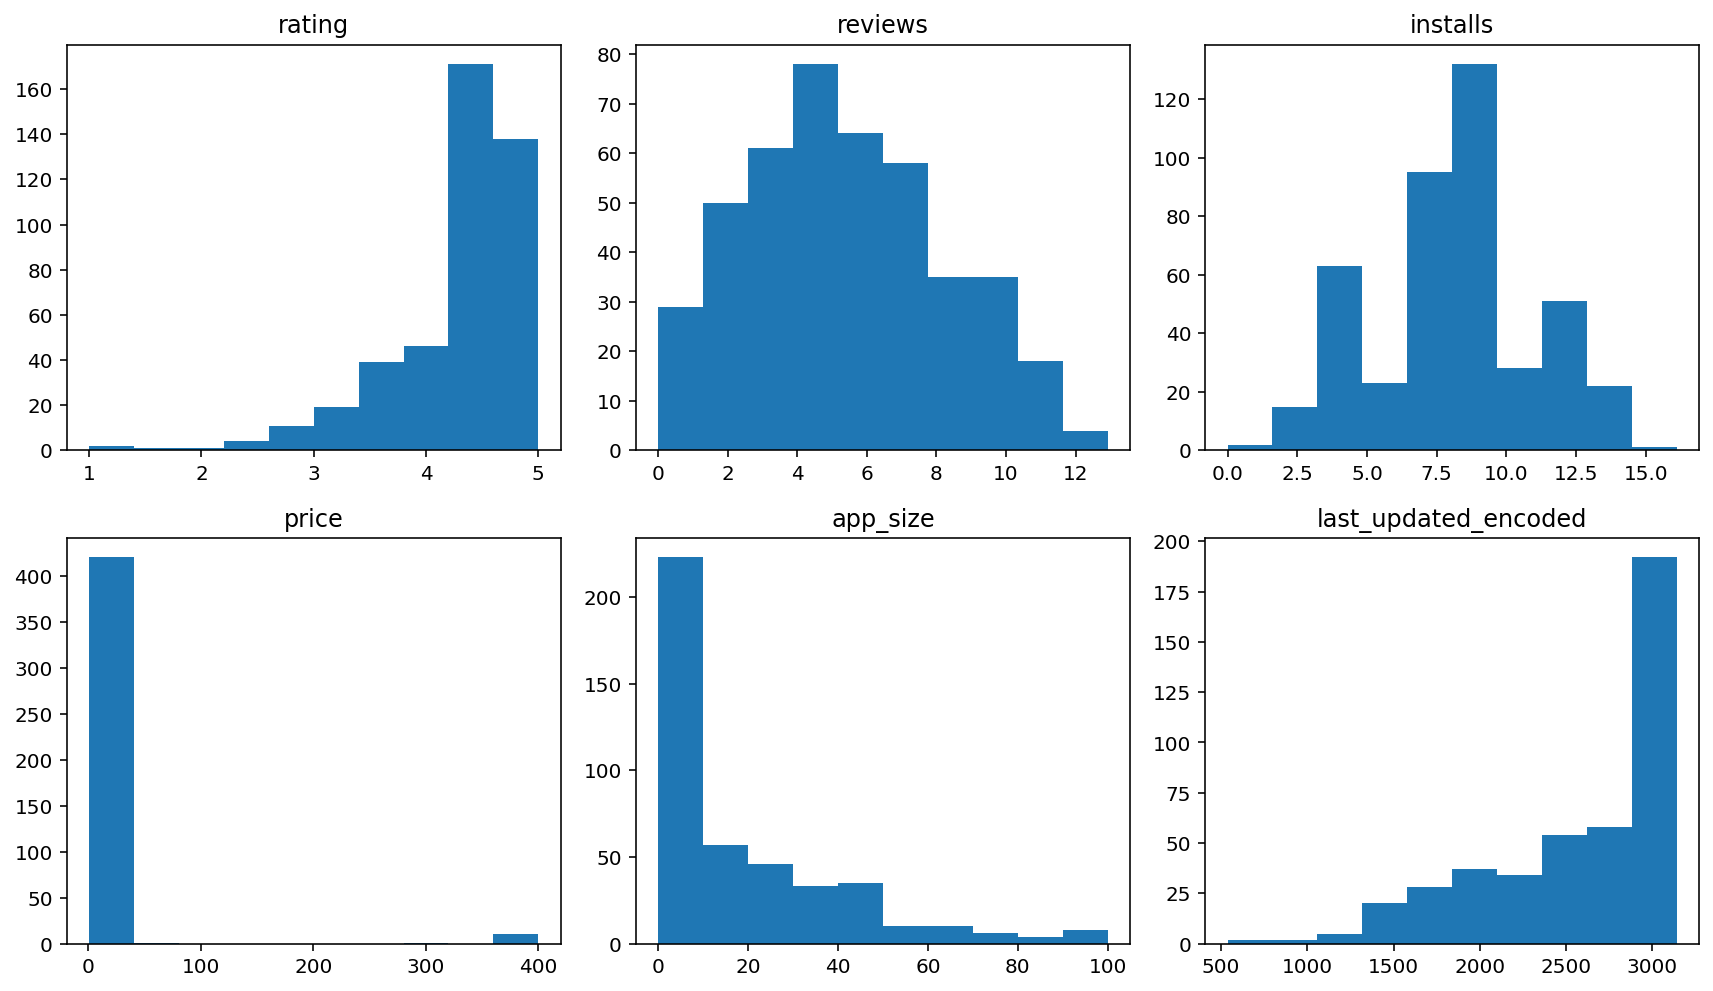

In [3]:
# numeric variables
numeric_vars = df.select_dtypes(np.number)

fig, axes = plt.subplots(nrows=2, ncols=int(len(numeric_vars.columns)/2), figsize = (12,7), )
axes = np.array(axes).flatten()

for i, ax in enumerate(axes):
    ax.hist(numeric_vars.iloc[:, i])
    ax.set_title(numeric_vars.columns[i])
    
plt.tight_layout()
plt.show()

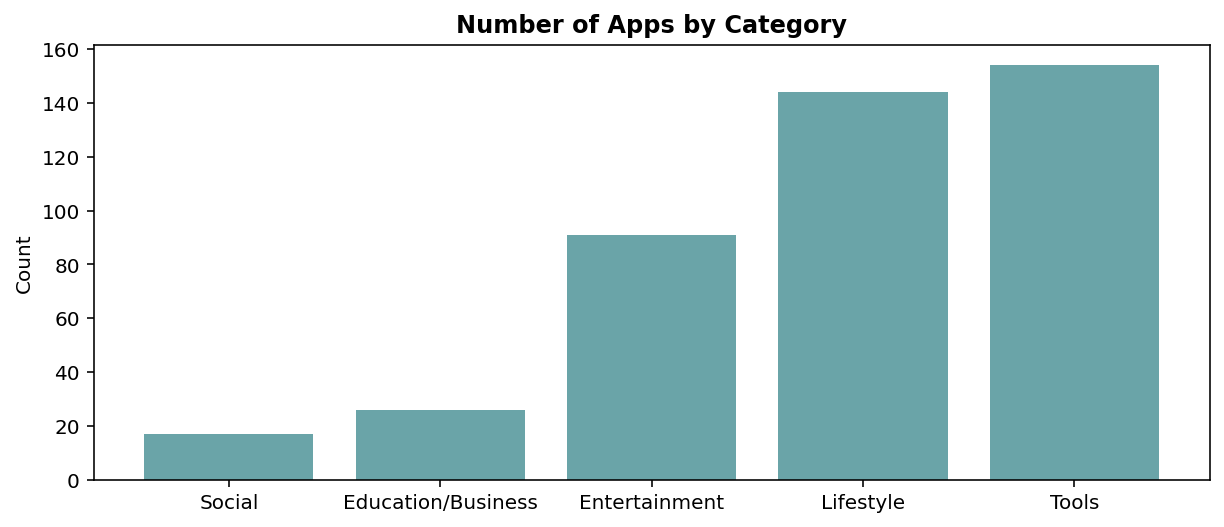

In [4]:
df_category = (df.groupby('category').count().sort_values('rating'))

fig, ax = plt.subplots(figsize=(10,4))

ax.bar(df_category.index, df_category['rating'], color='#6aa4a8')
ax.set_ylabel('Count')
ax.set_title('Number of Apps by Category', fontweight='bold')

plt.show()

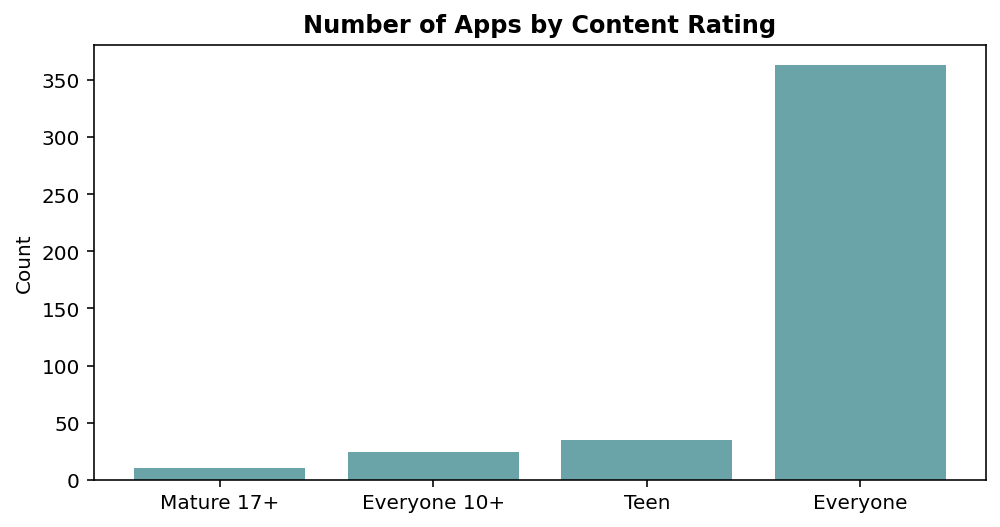

In [5]:
df_category = (df.groupby('content_rating').count().sort_values('rating'))

fig, ax = plt.subplots(figsize=(8,4))

ax.bar(df_category.index, df_category['rating'], color='#6aa4a8')
ax.set_ylabel('Count')
ax.set_title('Number of Apps by Content Rating', fontweight='bold')

plt.show()

# Initial model fit with all variables

In [6]:
# regress rating against all other variables
ystr = 'rating'
x_var = [col for col in df.columns if col != ystr]
xstr = '+'.join(x_var)

# build initial ols model 
model = smf.ols(f'{ystr}~{xstr}', data=df).fit()

# drop a variable in model 
x_var2 = x_var.copy()
x_var2.remove(set(x_var2).pop())
xstr_drop = '+'.join(x_var2)
model_drop = smf.ols(f'{ystr}~{xstr_drop}', data=df).fit()

print(model.summary())
# print(model_drop.summary())


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     5.939
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           1.38e-09
Time:                        17:21:31   Log-Likelihood:                -348.64
No. Observations:                 432   AIC:                             723.3
Df Residuals:                     419   BIC:                             776.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

# Influential Points 

## Cook's Distance 

In [9]:
# Much fewer influential points this time around! 

infl = model.get_influence()
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d
atyp_cook = np.abs(reg_cook) >= 4/len(df)
print(df.index[atyp_cook],reg_cook[atyp_cook])

Int64Index([ 28,  36,  61,  66,  73,  74,  87, 117, 136, 139, 149, 154, 155,
            159, 167, 201, 207, 209, 231, 237, 243, 253, 270, 279, 281, 289,
            342, 358, 377, 409],
           dtype='int64') 28    0.03876
36    0.01016
61    0.01066
66    0.03910
73    0.02230
74    0.01014
87    0.02904
117   0.05073
136   0.01555
139   0.02750
149   0.01819
154   0.01434
155   0.01074
159   0.01163
167   0.01033
201   0.01323
207   0.01168
209   0.00954
231   0.01522
237   0.01568
243   0.08214
253   0.01010
270   0.01104
279   0.01128
281   0.01079
289   0.01188
342   0.01264
358   0.01680
377   0.01610
409   0.08333
Name: cooks_d, dtype: float64


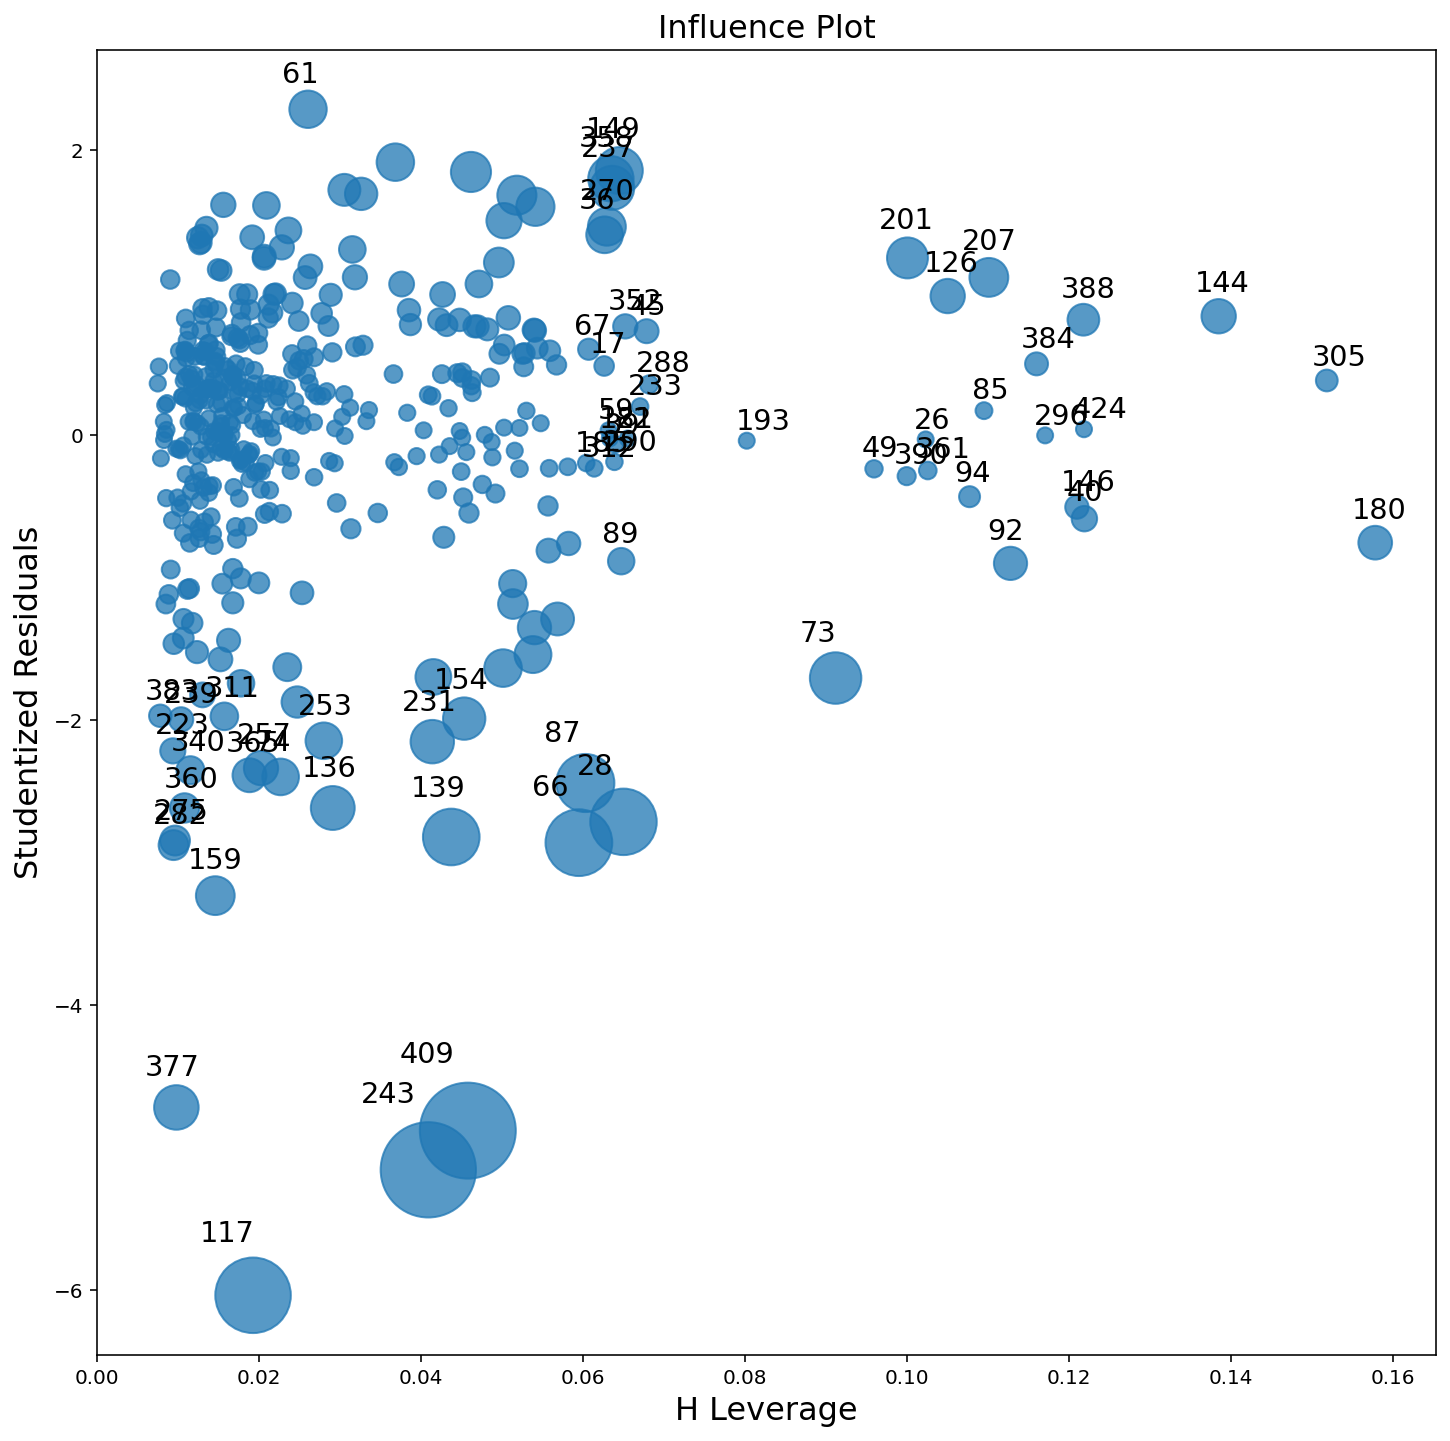

In [10]:
#graphical representation of the influences()
fig, ax = plt.subplots(figsize=(12,12))
fig=sm.graphics.influence_plot(model,ax=ax, criterion="cooks")

## Externally Studentized Residuals

In [11]:
#threshold externally studentized residuals --> what is shown on the y axis above 
import scipy
n=len(df)
p= 13
seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)

#detection - absolute value > threshold
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud  # identify all externally studentized residuals over the threshold 

#which ones?
print(df.index[atyp_stud],reg_studs[atyp_stud])

Int64Index([ 28,  61,  66,  74,  87, 117, 136, 139, 154, 159, 223, 231, 239,
            243, 253, 257, 275, 282, 311, 340, 360, 365, 377, 383, 409],
           dtype='int64') [-2.7127   2.28796 -2.85871 -2.39734 -2.44016 -6.0352  -2.61547 -2.819
 -1.98817 -3.23055 -2.21471 -2.14996 -1.99401 -5.15463 -2.14373 -2.3353
 -2.84392 -2.87586 -1.97228 -2.35014 -2.61509 -2.38572 -4.7169  -1.96841
 -4.87956]


## Final List of Influential Points

In [13]:
# Which points are considered influential points in both Externally Studentized Residuals and Cooks?

externally_studentized = set(df.index[atyp_stud])
cooks = set(df.index[atyp_cook])

influential_points = externally_studentized.intersection(cooks)

infl_points_list = list(influential_points)

influential_points

{28, 61, 66, 74, 87, 117, 136, 139, 154, 159, 231, 243, 253, 377, 409}

# New DF with Influential Points taken out 

In [14]:
df2= df.drop(infl_points_list)  
model2 = smf.ols(f'{ystr}~{xstr}', data=df2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     7.570
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           1.13e-12
Time:                        17:26:46   Log-Likelihood:                -224.10
No. Observations:                 417   AIC:                             474.2
Df Residuals:                     404   BIC:                             526.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          4.4700      0.149     29.971      0.000       4.177       4.763
category[T.Entertainment]         -0.0940      0.102     -0.921      0.358      -0.295       0.107
category[T.Lifestyle]             -0.0221      0.097     -0.228      0.819      -0.212       0.168
category[T.Social]                -0.1319      0.145     -0.913      0.362      -0.416       0.152
category[T.Tools]                 -0.0077      0.096     -0.080      0.936      -0.197       0.182
content_rating[T.Everyone 10+]    -0.0181      0.092     -0.196      0.845      -0.199       0.163
content_rating[T.Mature 17+]       0.1451      0.137      1.060      0.290      -0.124       0.414
content_rating[T.Teen]             0.0755      0.082      0.922      0.357      -0.085       0.236
reviews                            0.1577      0.021      7.441      0.000       0.116       0.199
installs                          -0.1590      0.022     -7.394      0.000      -0.201      -0.117
price                             -0.0013      0.000     -3.783      0.000      -0.002      -0.001
app_size                           0.0011      0.001      1.048      0.295      -0.001       0.003
last_updated_encoded               0.0001   3.79e-05      3.038      0.003    4.06e-05       0.000
==============================================================================
Omnibus:                       80.725   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.342
Skew:                          -1.102   Prob(JB):                     4.54e-32
Kurtosis:                       4.858   Cond. No.                     2.79e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Residual Variance

## Residuals Vs Fitted Values Plot

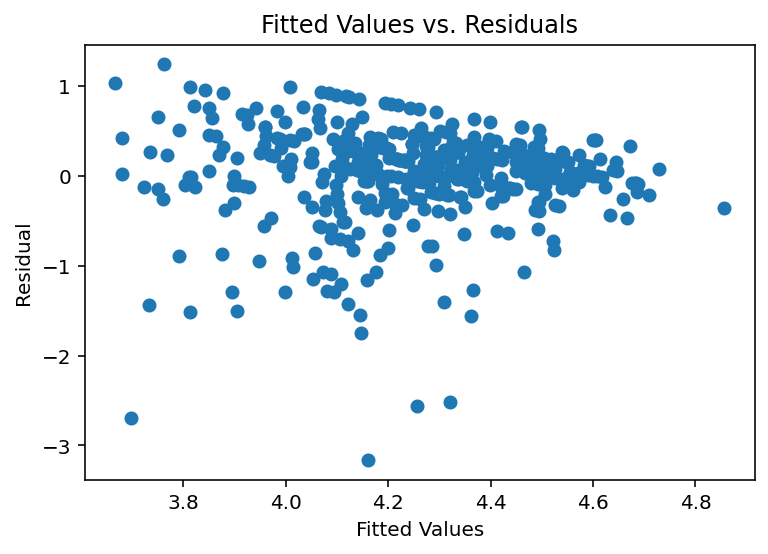

In [15]:
# Original model

p = model.fittedvalues
res = model.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

plt.show()

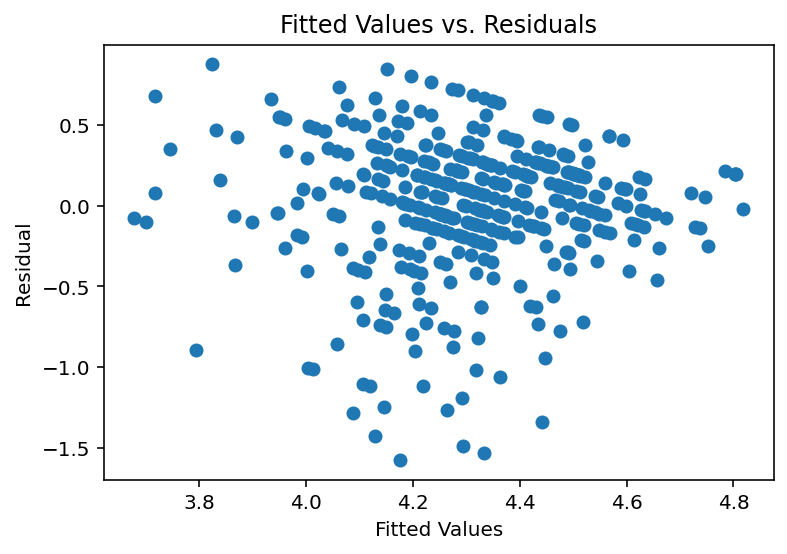

In [34]:
# Model without influential points 

p2 = model2.fittedvalues
res2 = model2.resid
plt.scatter(p2,res2)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")

plt.show()

## BP Test

In [20]:
#Breusch-Pagan for Heteroskedasticity - Original Model
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 44.46277636233585, 'LM-Test p-value': 1.2733473154829109e-05}


In [21]:
#Breusch-Pagan for Heteroskedasticity - Model without Influential Points 
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model2.resid, model2.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 46.12914906576023, 'LM-Test p-value': 6.591730514066335e-06}


Since the p-value is less than 0.05, we reject the null that the variance of error is constant in favor of the alternate hypothesis, which states that variace of error changes with predictors. Thus, there is significant heteroskedasticity in both the original full model and the full model without influential points.

However, the p-value did significantly decrease. When we ran this on the very first model before the log transformation, the p-value was 2.2508840998165504e-30

# Normality

## QQ Plot

In [24]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

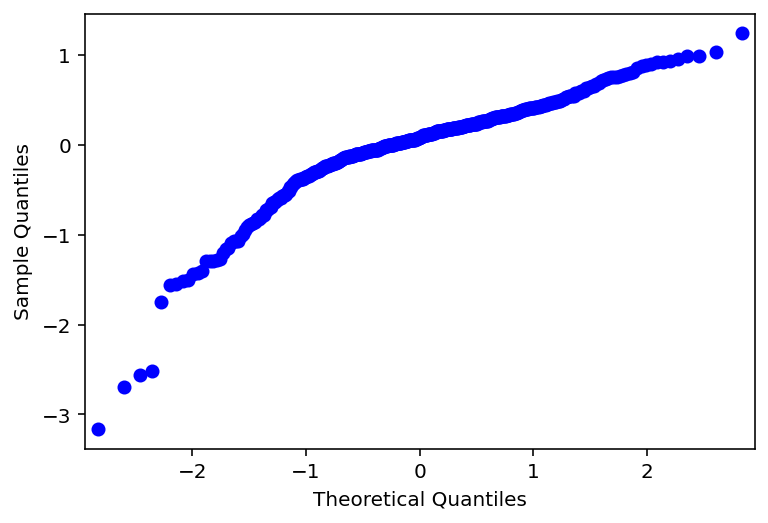

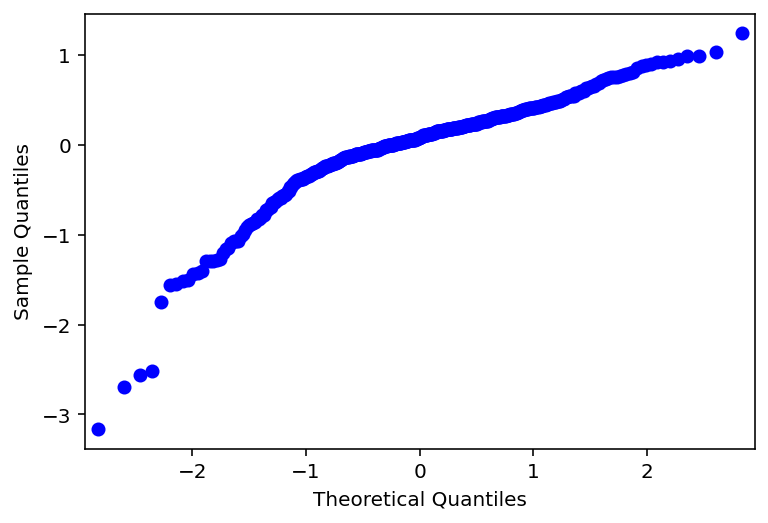

In [25]:
# Original model

sm.qqplot(model.resid)

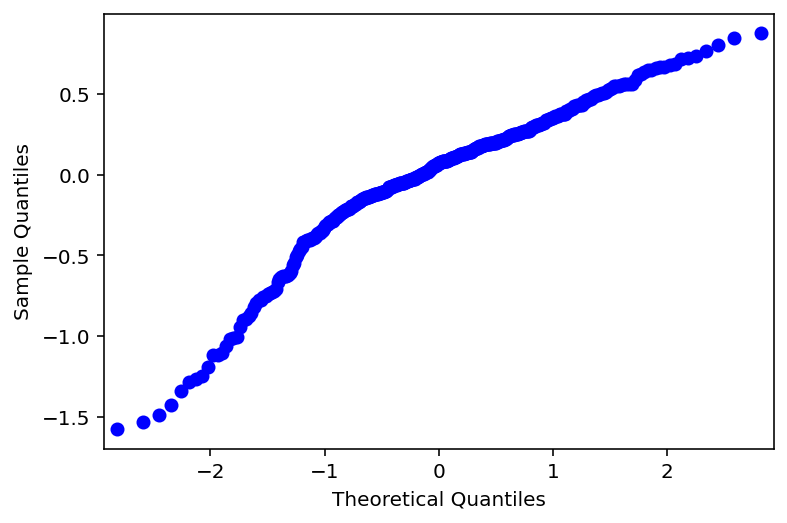

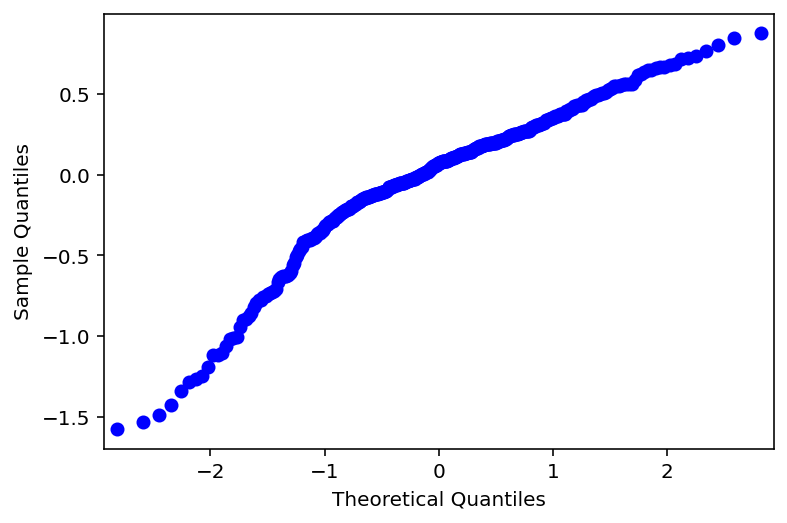

In [26]:
# Model without influential points 
sm.qqplot(model2.resid)

# JB Test

## Original Model

The JB value for the original full model has a p-value of zero. With a JB test, H0 states that the residuals are approximately normal and H1 states that residuals are not close to normal. Since our p-value for the JB stat is 0.000, we reject the null in favor of the alternate, stating that residuals are not close to normal

## Model without influential points¶


The JB value for the model without influential points has a lower JB value of 1525.458. However, the p-value is still zero, meaning the residuals are not close to being normally distributed. However, given that the sample size of 432 > 30p = 30 * 13 = 390, CLT ensures that the normality assumption is taken care of